# Property Clustring

In [1]:
# libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Loading Data

In [2]:
#Step 1 — Load only what is needed
use_cols = [
    "PropertyID",
    "Currentavmvalue",
    "equityValue",
    "EquityPercent",
    "LOO",
    "Age",
    "FinalOwnerType",
    "Beds",
    "FullBaths",
    "HalfBaths",
    "Sqft",
    "building_condition",
    "owneroccupied",
    "multi_owner",
    "Lien",
    "TCounty",
    "TState",
    "TZip5",
    "Tzip4",
]

df_combined = pd.read_csv(os.path.join("data", "combined_output.csv"),
    usecols=use_cols,
    low_memory=False
)

# print df shape
print("df_combined shape: ", df_combined.shape)

df_combined shape:  (5300825, 19)


In [3]:
# df_market_map = pd.read_csv("county_state_market_mapping.csv")

df_market_map = pd.read_csv(os.path.join("data", "county_market_lookup.csv"))



In [4]:
df_market_map = (
    df_market_map[
        ["state_lower", "county_lower", "Market"]
    ]
    .drop_duplicates()
)

## Structured Data Exploration

In [5]:
# Structurally reliable features (near-complete)
tier1_col = [
   'Currentavmvalue',
   'equityValue',
   'EquityPercent',
   'FinalOwnerType',
   'Age',
   'LOO' 
]

In [6]:
df_combined.columns

Index(['PropertyID', 'Currentavmvalue', 'equityValue', 'EquityPercent',
       'TCounty', 'TState', 'TZip5', 'Tzip4', 'FinalOwnerType',
       'owneroccupied', 'building_condition', 'multi_owner', 'Lien', 'LOO',
       'Beds', 'FullBaths', 'HalfBaths', 'Sqft', 'Age'],
      dtype='object')

### 1. Data processing

In [7]:
# Step 2.0 - Normalize geography

df_combined['TCounty'] = df_combined['TCounty'].str.lower()
df_combined['TCounty'] = df_combined['TCounty'].str.replace(" ","")
df_combined['TCounty'] = df_combined['TCounty'].str.replace("'","")
df_combined['TCounty'] = df_combined['TCounty'].str.strip()
df_combined['TCounty'] = df_combined['TCounty'].str.replace("county","")
df_combined['TCounty'] = df_combined['TCounty'].str.replace(".","")
    
df_combined['TState'] = df_combined['TState'].str.lower()
df_combined['TState'] = df_combined['TState'].str.replace(" ","")
df_combined['TState'] = df_combined['TState'].str.replace("'","")
df_combined['TState'] = df_combined['TState'].str.strip()

df_combined["state_lower"] = (df_combined["TState"].astype(str).str.lower().str.strip())
df_combined["county_lower"] = (df_combined["TCounty"].astype(str).str.lower().str.strip())

df_combined = df_combined.merge(
    df_market_map,
    how="left",
    on=["state_lower", "county_lower"]
)

#df_combined["Market"] = df_combined["Market"].fillna("Other")

In [8]:
df_combined['Market'].value_counts(dropna=False)

Market
DC Metro         1859771
Baltimore        1401003
Hampton Roads     650993
Richmond          523283
NaN               442312
Philadelphia      423463
Name: count, dtype: int64

In [9]:
# Step 2.1 — Encode informative missingness
df_combined["LOO_missing"] = df_combined["LOO"].isna().astype(int)

# step 2.2 log transformation of LOO:
# because Early tenure differences matter a lot, but Very long tenure differences matter less, so keeping LOO linear, means: “90 → 100 years is as important as 20 → 30 years.” 
# Which is almost certainly false behaviorally.

df_combined["LOO_log"] = np.log1p(df_combined["LOO"])

# Step 2.3 - Encode Categorical features
df_combined['is_AO'] = (df_combined['FinalOwnerType'] == 'AO').astype(int)


#Step 3.1 — AVM bins (binned current market valuation of the property) --> to be used at sampleing stage not clustering
df_combined["AVM_bin"] = pd.qcut(  # creates Equal-width bins
    df_combined["Currentavmvalue"],
    q=10,
    duplicates="drop"
)

#step 3.2 - log transformation
df_combined["Currentavmvalue_log"] = np.log1p(df_combined["Currentavmvalue"])


# Age: Cap at 100 years
df_combined["is_very_old"] = (df_combined["Age"] > 100).astype(int)  # a secondary binary feature

df_combined["Age_capped"] = df_combined["Age"].clip(upper=100)

#Step 4 - Data cleaning
# 1.drop rows with EquityPercent >100%
df_combined = df_combined[df_combined["EquityPercent"] <= 100]

# EquityPercent == 100 must be treated as a state (is_fully_paid)
df_combined["is_fully_paid"] = (df_combined["EquityPercent"] == 100).astype(int)

# create continuous part of 'EquityPercent'
df_combined["EquityPercent_cont"] = df_combined["EquityPercent"].where(
    df_combined["EquityPercent"] < 100
)

df_combined["PropertyID_join"] = df_combined["PropertyID"].astype(str)

<Axes: ylabel='Frequency'>

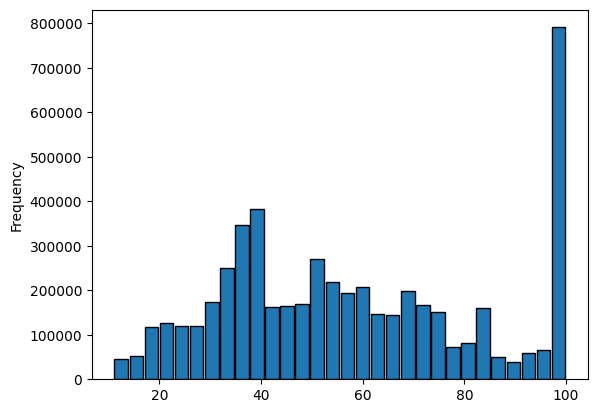

In [10]:
df_combined["Age_capped"].plot.hist(bins=30, edgecolor="black", rwidth=0.9)

### 2. Stratified sampling

In [11]:
# Step 4 — Stratified sampling
target_size = 150_000
sample_frac = target_size / len(df_combined)

strata_cols = [
    #"FinalOwnerType",
    "AVM_bin",
    "LOO_missing", # to get same fraction of missingness in the sample
]


#--
#- Large strata contribute many rows
#- Small but important strata are preserved
#- Rare combinations don’t disappear
#--
sampled_df = (
    df_combined
    .groupby(strata_cols, group_keys=False, observed=False)
    .apply(lambda x: x.sample(
        frac=sample_frac,
        random_state=42
    ))
)

# step 5 — Save
sampled_df.to_csv(os.path.join("data",
    "combined_output_stratified_sample.csv"),
    index=False
)

C:\Users\Home\AppData\Local\Temp\ipykernel_13076\3676021191.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(


#### 2.1 Sample validation

NOTE: this sample is a faithful representation of the core investor-targetable population

In [12]:
sampled_df.shape

(149999, 32)

In [13]:
sampled_df["FinalOwnerType"].value_counts(normalize=True)

FinalOwnerType
AO    0.52151
OO    0.47849
Name: proportion, dtype: float64

In [14]:
df_combined["FinalOwnerType"].value_counts(normalize=True)

FinalOwnerType
AO    0.520437
OO    0.479563
Name: proportion, dtype: float64

In [15]:
# Is Missingness preserved? (this is critical)
sampled_df[["LOO_missing"]].mean()


LOO_missing    0.229288
dtype: float64

In [16]:
df_combined[["LOO_missing"]].mean()

LOO_missing    0.229285
dtype: float64

In [17]:
# AVM distribution sanity
sampled_df["Currentavmvalue"].describe()

count    1.499990e+05
mean     3.618231e+05
std      1.706665e+05
min      4.000000e+04
25%      2.392080e+05
50%      3.300000e+05
75%      4.450000e+05
max      2.046517e+06
Name: Currentavmvalue, dtype: float64

In [18]:
df_combined['Currentavmvalue'].describe()

count    5.300800e+06
mean     3.617401e+05
std      1.705190e+05
min      4.000000e+04
25%      2.396440e+05
50%      3.300000e+05
75%      4.455102e+05
max      2.172704e+06
Name: Currentavmvalue, dtype: float64

Note:

the max in the sample vs original df shows discrapency.

Are properties above $1.1M strategically meaningful for investor conversion?

- If no → proceed as-is. The sample is fine. (Going with this option for now)

- If yes → keep top 0.1% by AVM (sample separately) and sample the rest and then combine 

#### 2.2 Investigation

In [19]:
sampled_df['FinalOwnerType'].value_counts(normalize=True, dropna=False)

FinalOwnerType
AO    0.52151
OO    0.47849
Name: proportion, dtype: float64

==> 'FinalOwnerType' is dangerous and valuable. should not let FinalOwnerType directly drive distance in the first clustering pass. Should be excluded from distance metric to avoid trivial soltion:
“Cluster 1 = AO, Cluster 2 = OO”

In [20]:
sampled_df.groupby("FinalOwnerType")[
    ["EquityPercent", "LOO_missing"]
].mean()

,EquityPercent,LOO_missing
FinalOwnerType,,
AO,84.238386,0.222573
OO,74.699330,0.236607


Conclusion:
- Missing LOO is not explained by ownership type
- AO tend to be further along the financial lifecycle/ But many OO are also high-equity/ And many AO are still leveraged

so 'FinalOwnerType' should inform ranking, not geometry. It carries secondary interpretation.

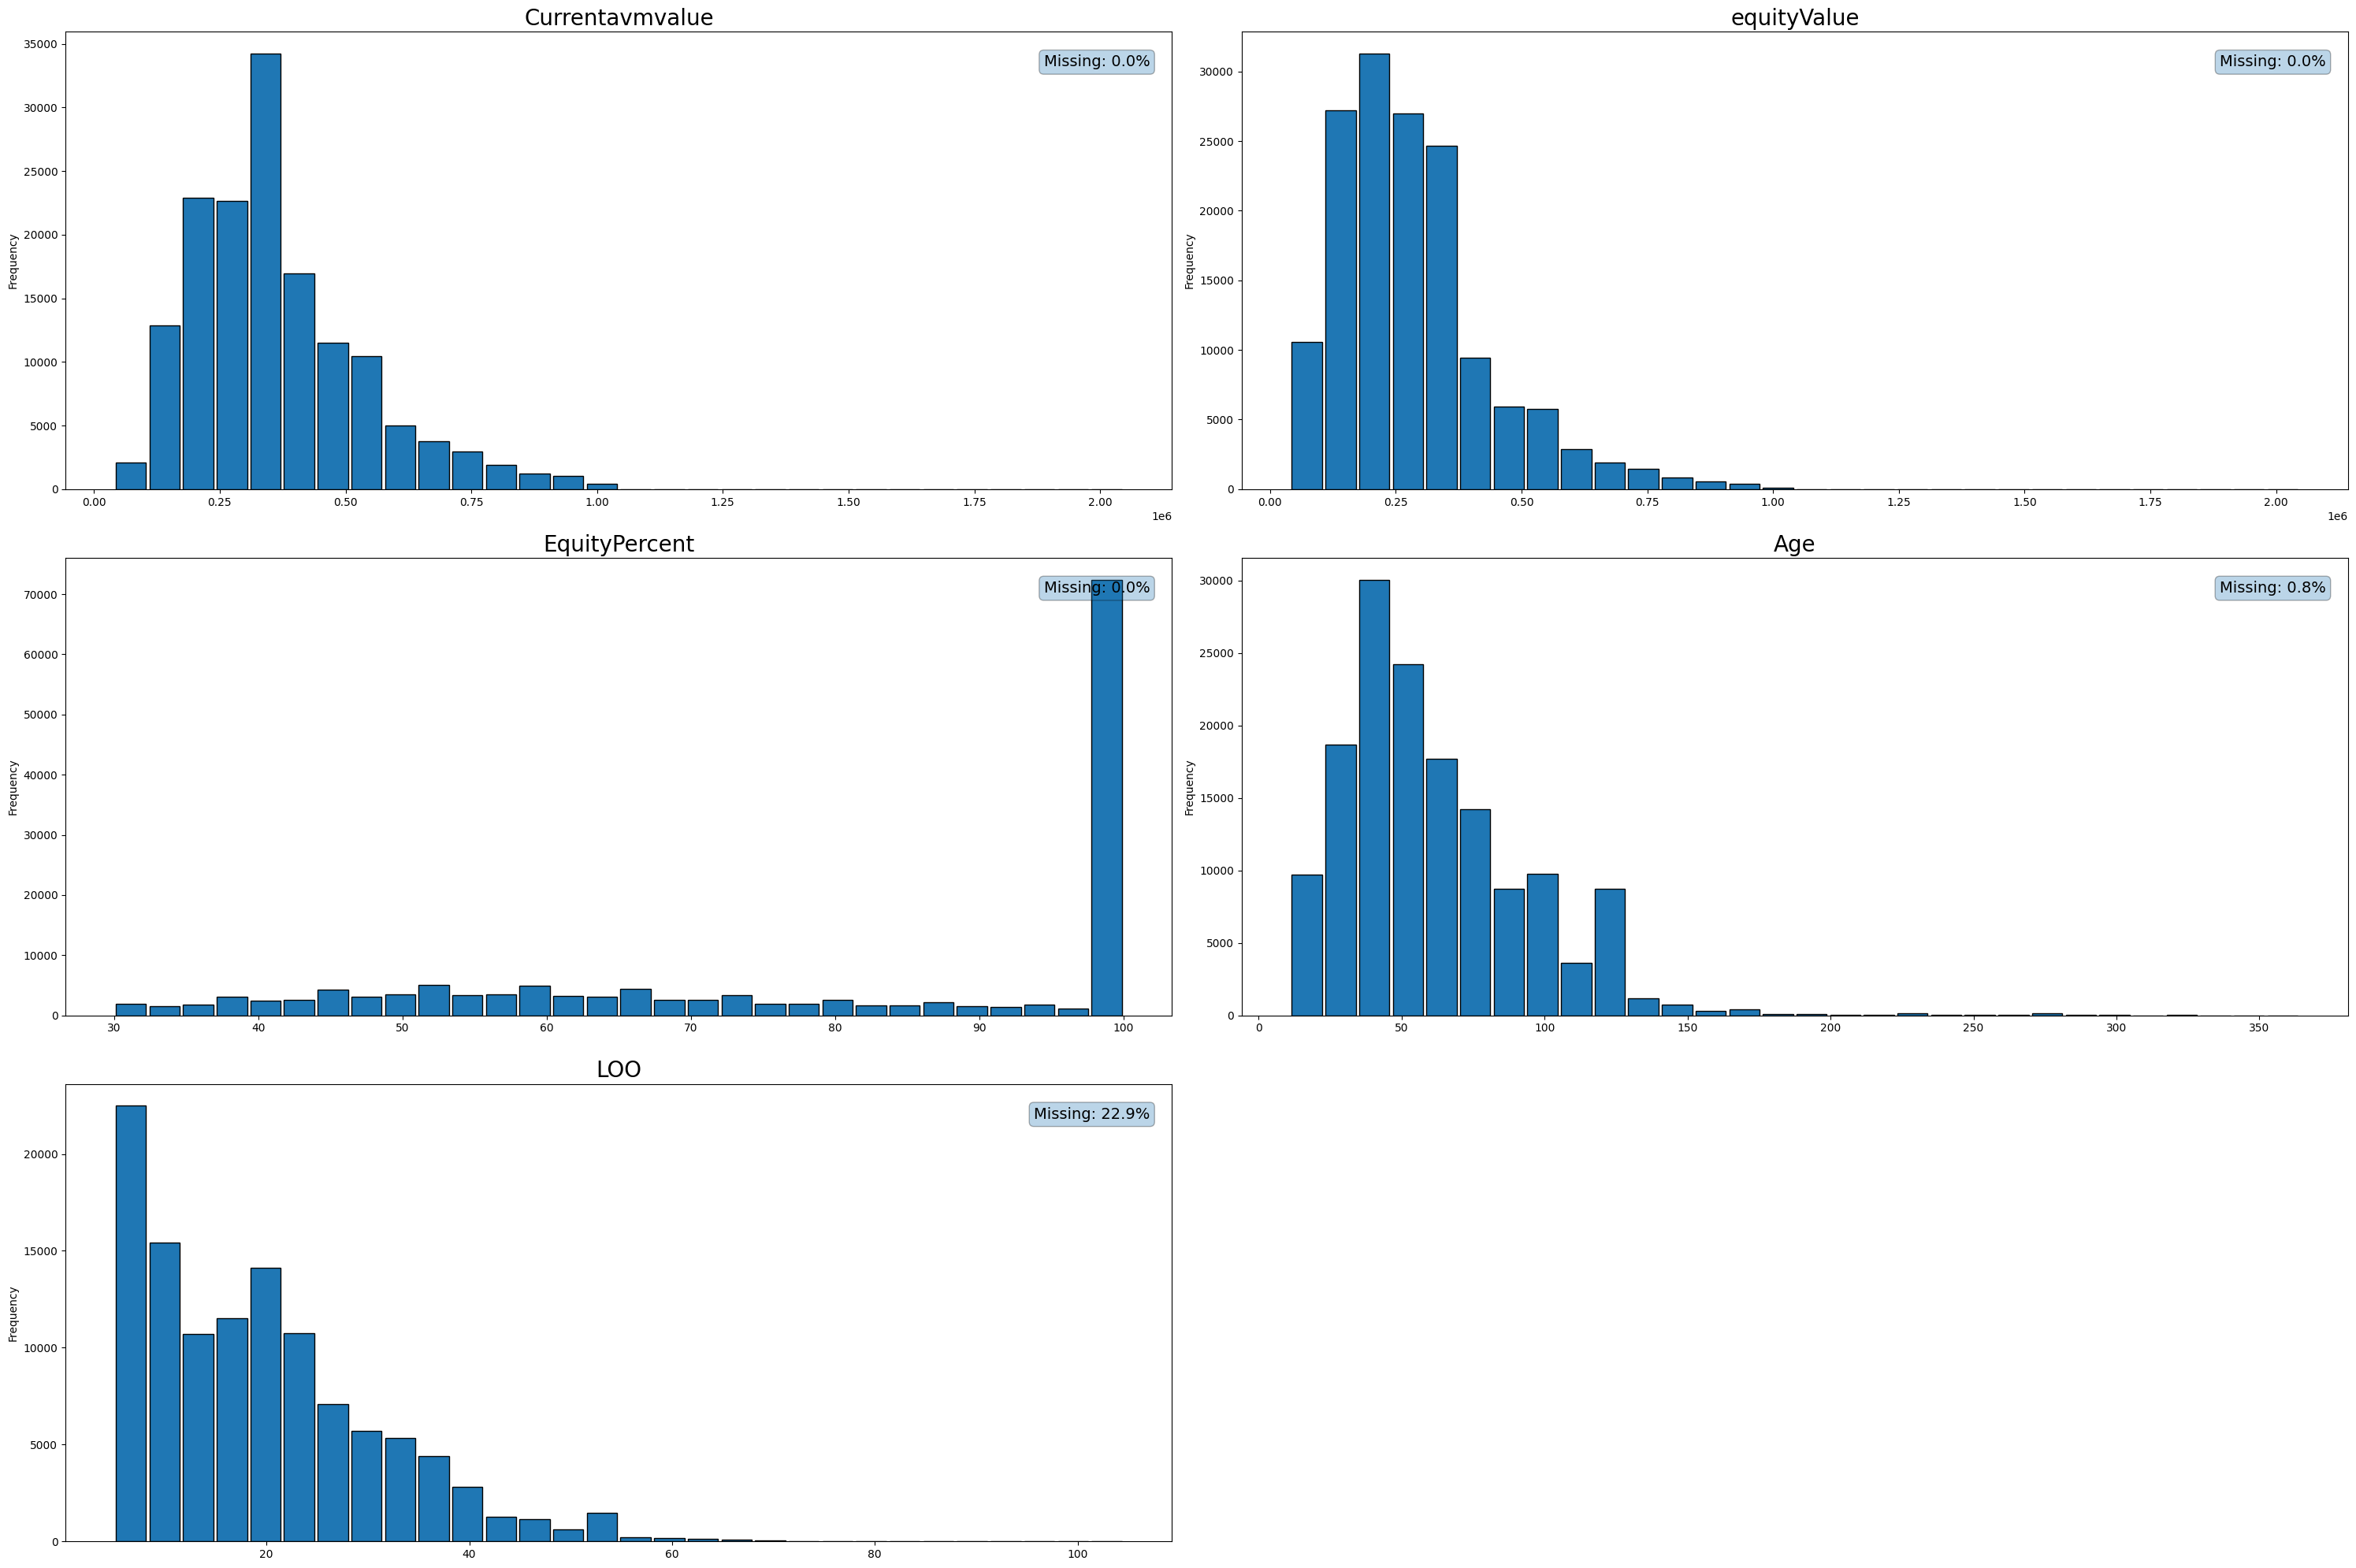

In [21]:
# make a 2 by 2 plot
plt.figure(figsize=(30, 20))
# tier1_col exclufing final owner type
col = [c for c in tier1_col if c != "FinalOwnerType"]

for i, col in enumerate(col):
    ax = plt.subplot(3, 2, i + 1)
    ax.set_title(col,fontsize=20)
    sampled_df[col].plot.hist(bins=30, edgecolor="black", rwidth=0.9)

    missing_pct = sampled_df[col].isna().mean() * 100

    ax.text(
        0.98, 0.95,
        f"Missing: {missing_pct:.1f}%",
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize=14,
        bbox=dict(boxstyle="round,pad=0.3", alpha=0.3)
    )
    
    plt.tight_layout()

#### 2.3 Observation:

### 1. EquityPercent = 100 is a proxy for ownership psychology, not just finance.

From a behavioral standpoint, these owners are different:

- Often long LOO
- Often older properties
- Frequently absentee owners
- Emotionally detached from the property
- Much easier investor conversations

==> EquityPercent == 100, is_fully_paid? or EquityPercent_capped?

In [22]:
# How many are fully paid?
sampled_df['is_fully_paid'].mean()

0.4774765165101101

In [23]:
# Relationship with LOO
sampled_df.groupby(sampled_df['is_fully_paid'])["LOO"].describe()

,count,mean,std,min,25%,50%,75%,max
is_fully_paid,,,,,,,,
0,68000.0,16.915749,9.978993,4.982888,8.583162,15.509925,22.036961,85.002053
1,47606.0,22.761469,12.871858,4.988364,11.561944,21.289528,31.630390,104.514716


Text(0.3, 0.3, 'Mean: 22.8')

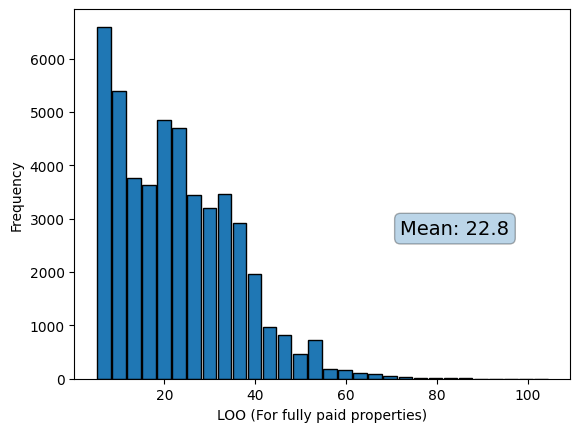

In [24]:
# plot LOO histogram for fully paid

sampled_df[sampled_df['is_fully_paid']==1]["LOO"].plot.hist(bins=30, edgecolor="black", rwidth=0.9)

# set labels
plt.xlabel("LOO (For fully paid properties)")
plt.ylabel("Frequency")

meanLoo = round(sampled_df[sampled_df['is_fully_paid']==1]["LOO"].mean(),1)
# print the mean value
#plt.text(100, 5000, f'mean LOO:{meanLoo}')
plt.text(
        0.3, 0.3,
        f"Mean: {meanLoo:.1f}",
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize=14,
        bbox=dict(boxstyle="round,pad=0.3", alpha=0.3))

In [25]:
sampled_df.head(5)

,PropertyID,Currentavmvalue,equityValue,EquityPercent,TCounty,TState,TZip5,Tzip4,FinalOwnerType,owneroccupied,building_condition,multi_owner,Lien,LOO,Beds,FullBaths,HalfBaths,Sqft,Age,state_lower,county_lower,Market,LOO_missing,LOO_log,is_AO,AVM_bin,Currentavmvalue_log,is_very_old,Age_capped,is_fully_paid,EquityPercent_cont,PropertyID_join
1278390,62978627,155113.0,155113,100,dorchester,md,21643.0,3628.0,OO,NaN,NaN,NaN,NaN,21.415469,NaN,NaN,NaN,NaN,94.0,md,dorchester,Baltimore,0,3.109751,0,"(39999.999, 174000.0]",11.951916,0,94.0,1,NaN,62978627
2573734,142464329,147000.0,147000,100,hopewellcity,va,23860.0,6209.0,AO,NaN,NaN,NaN,NaN,6.699521,NaN,NaN,NaN,NaN,54.0,va,hopewellcity,Richmond,0,2.041158,1,"(39999.999, 174000.0]",11.898195,0,54.0,1,NaN,142464329
3360356,115953760,170000.0,95493,56,montgomery,pa,19525.0,9580.0,AO,NaN,NaN,NaN,NaN,40.010951,NaN,NaN,NaN,NaN,135.0,pa,montgomery,Philadelphia,0,3.713839,1,"(39999.999, 174000.0]",12.043560,1,100.0,0,56.0,115953760
1298661,64562106,156199.0,156199,100,baltimorecity,md,21239.0,3618.0,OO,NaN,NaN,NaN,NaN,33.596167,NaN,NaN,NaN,NaN,74.0,md,baltimorecity,Baltimore,0,3.543743,0,"(39999.999, 174000.0]",11.958893,0,74.0,1,NaN,64562106
1101153,62762942,91885.0,91885,100,caroline,md,21636.0,1233.0,AO,NaN,NaN,NaN,NaN,6.899384,NaN,NaN,NaN,NaN,58.0,md,caroline,Baltimore,0,2.066785,1,"(39999.999, 174000.0]",11.428304,0,58.0,1,NaN,62762942


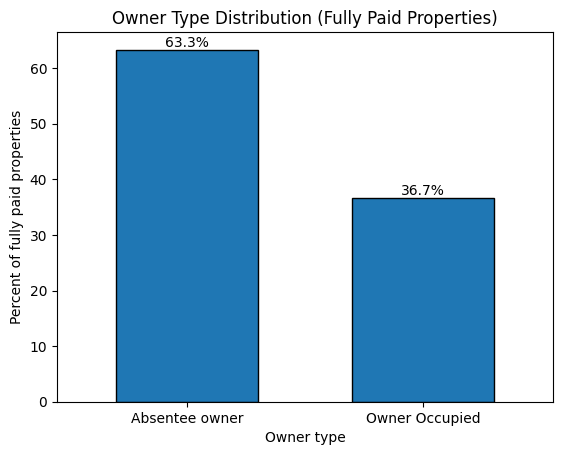

In [26]:
# plot AO histograms for fully paid

ownership_pct = sampled_df[sampled_df["is_fully_paid"] == 1]["is_AO"].value_counts(normalize=True) * 100


ax = ownership_pct.rename({1: "Absentee owner", 0: "Owner Occupied"}).plot.bar(
    edgecolor="black",
    width=0.6
)

ax.set_ylabel("Percent of fully paid properties")
ax.set_xlabel("Owner type")
ax.set_title("Owner Type Distribution (Fully Paid Properties)")

# annotate bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height:.1f}%",
        (p.get_x() + p.get_width() / 2, height),
        ha="center",
        va="bottom"
    )
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()


==> Conclusion: 
- Fully paid ownership and absentee ownership are correlated, but not redundan
- Baseline rate of AO is 52%
- Being fully paid increases the likelihood of being absentee
- is_AO is a good secondary explanatory variable
    - If you had let is_AO into the distance metric --> Clusters would lean heavily toward AO/OO separation

In investor terms, fully paid owners are:
- More likely to be absentee (63.3%)
- More likely to sell directly
- Less constrained by lenders
- But one in three fully paid owners still live in the home (36.7%)

#### Missing LOO is not “unknown” — it’s a proxy state

In [27]:
df_missing_loo = sampled_df[sampled_df["LOO_missing"]==1]
df_non_missing_loo = sampled_df[sampled_df["LOO_missing"]==0]

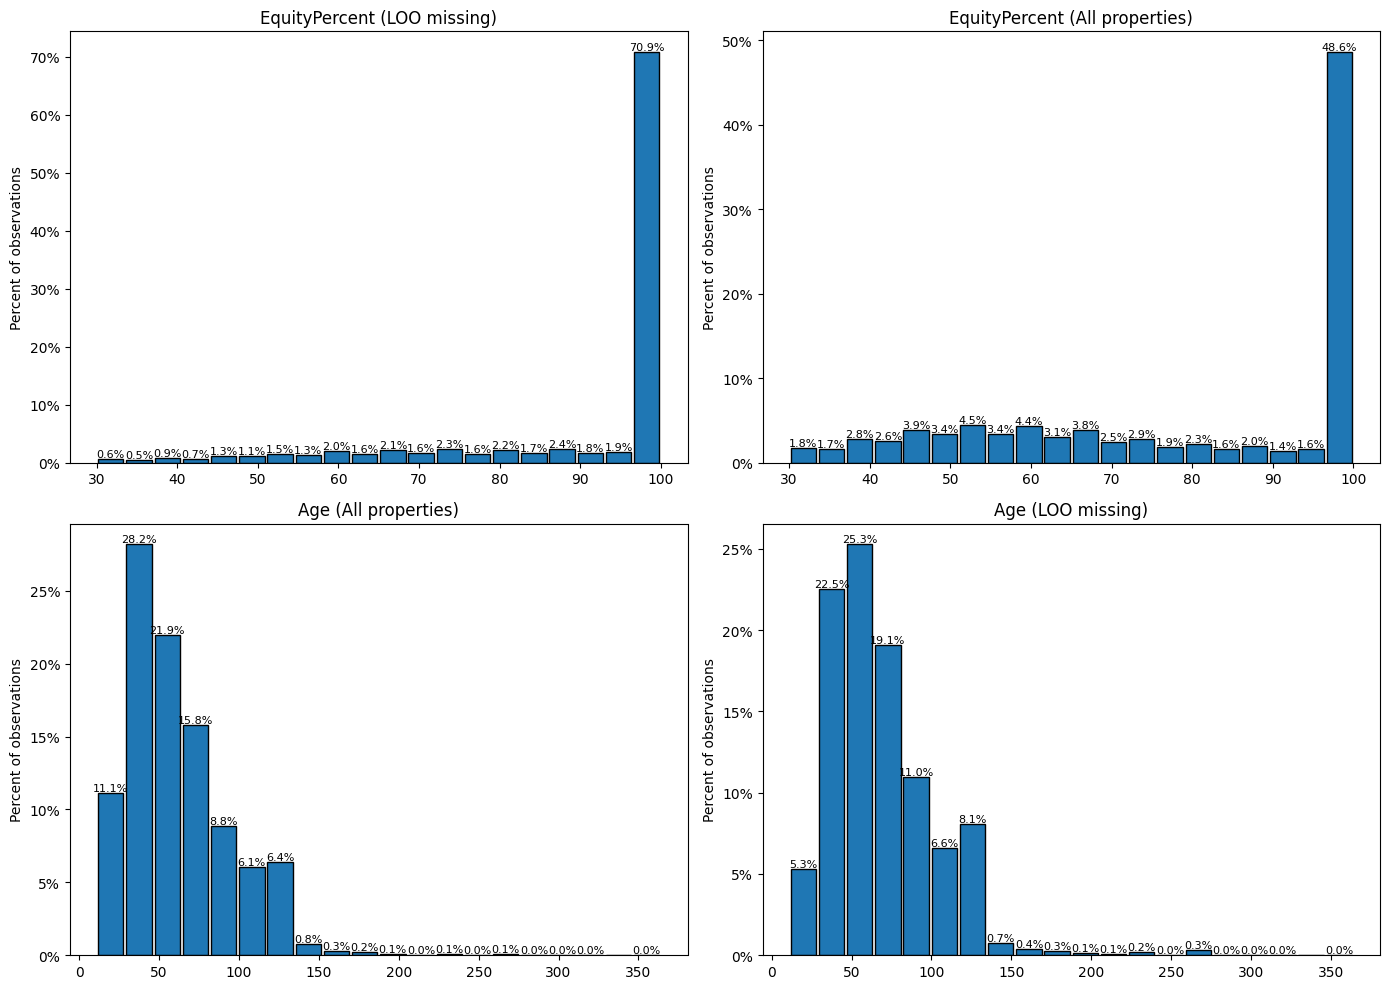

In [28]:
def percent_hist(ax, data, bins, xlabel, title):
    weights = np.ones(len(data)) / len(data) * 100

    ax.hist(
        data,
        bins=bins,
        weights=weights,
        edgecolor="black",
        rwidth=0.9
    )

    #ax.set_xlabel(xlabel)
    ax.set_ylabel("Percent of observations")
    ax.set_title(title)
    ax.yaxis.set_major_formatter(lambda y, _: f"{y:.0f}%")

    # annotate bars
    for patch in ax.patches:
        height = patch.get_height()
        if height > 0:
            ax.annotate(
                f"{height:.1f}%",
                (patch.get_x() + patch.get_width() / 2, height),
                ha="center",
                va="bottom",
                fontsize=8
            )

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Row 1: EquityPercent ---
percent_hist(
    ax=axes[0, 0],
    data=df_missing_loo["EquityPercent"],
    bins=20,
    xlabel="EquityPercent",
    title="EquityPercent (LOO missing)"
)

percent_hist(
    ax=axes[0, 1],
    data=sampled_df["EquityPercent"],
    bins=20,
    xlabel="EquityPercent",
    title="EquityPercent (All properties)"
)

# --- Row 2: Age ---
percent_hist(
    ax=axes[1, 0],
    data=sampled_df["Age"].dropna(),
    bins=20,
    xlabel="Age",
    title="Age (All properties)"
)

percent_hist(
    ax=axes[1, 1],
    data=df_missing_loo["Age"].dropna(),
    bins=20,
    xlabel="Age",
    title="Age (LOO missing)"
)

plt.tight_layout()
plt.show()


==> conclusion:
- LOO has two meanings depending on whether it exists.
    - Majority of missing LOO are fully paied properties ~ 71%
- Age distribution does not matter in LOO (Missing LOO is not about the house being older)


<Axes: ylabel='Frequency'>

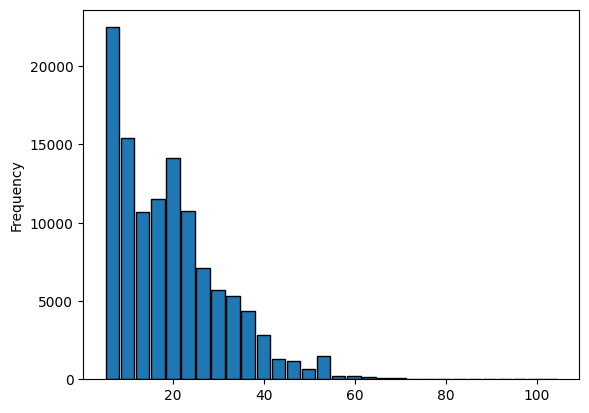

In [29]:
sampled_df[sampled_df['LOO'].notna()]['LOO'].plot.hist(bins=30, edgecolor="black", rwidth=0.9)

In [30]:
sampled_df['Currentavmvalue'].describe()

count    1.499990e+05
mean     3.618231e+05
std      1.706665e+05
min      4.000000e+04
25%      2.392080e+05
50%      3.300000e+05
75%      4.450000e+05
max      2.046517e+06
Name: Currentavmvalue, dtype: float64

### 3. Assembling a model of ownership behavior

#### Step 1 — Sanity check

In [31]:
cluster_features = [
    "Currentavmvalue_log",
    "is_fully_paid",
    "EquityPercent_cont",
    "LOO_log",
    "LOO_missing",
    "Age_capped"
]

sampled_X = sampled_df[cluster_features]

sampled_X.info()
sampled_X.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 149999 entries, 1278390 to 4387061
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Currentavmvalue_log  149999 non-null  float64
 1   is_fully_paid        149999 non-null  int32  
 2   EquityPercent_cont   78378 non-null   float64
 3   LOO_log              115606 non-null  float64
 4   LOO_missing          149999 non-null  int32  
 5   Age_capped           148732 non-null  float64
dtypes: float64(4), int32(2)
memory usage: 6.9 MB


,Currentavmvalue_log,is_fully_paid,EquityPercent_cont,LOO_log,LOO_missing,Age_capped
count,149999.000000,149999.000000,78378.000000,115606.000000,149999.000000,148732.000000
mean,12.690173,0.477477,61.100398,2.849708,0.229288,58.106083
std,0.475633,0.499494,17.206326,0.578979,0.420376,25.635954
min,10.596660,0.000000,30.000000,1.788903,0.000000,11.000000
25%,12.385093,0.000000,48.000000,2.349058,0.000000,37.000000
50%,12.706851,0.000000,59.000000,2.928535,0.000000,54.000000
75%,13.005832,1.000000,73.000000,3.278912,0.000000,77.000000
max,14.531650,1.000000,99.000000,4.658850,1.000000,100.000000


In [32]:
sampled_X.isnull().sum()

Currentavmvalue_log        0
is_fully_paid              0
EquityPercent_cont     71621
LOO_log                34393
LOO_missing                0
Age_capped              1267
dtype: int64

#### Step 2 — Handle intentional NaNs

For distance-based clustering, the cleanest option is:

- Replace intentional NaNs with 0
- Rely on the corresponding binary flag to explain why it’s zero

In [33]:
max_loo_log = max(sampled_X['LOO_log'])
max_equitypercent_cont = 100
max_age_capped = 100

In [34]:
#sampled_X.loc[sampled_X['LOO_log'].isna(),'LOO_log'] = max_loo_log
#sampled_X.loc[sampled_X['EquityPercent_cont'].isna(),'EquityPercent_cont'] = max_equitypercent_cont
sampled_X.loc[sampled_X['Age_capped'].isna(),'Age_capped'] = max_age_capped

sampled_X_filled = sampled_X.fillna(0)

In [35]:
sampled_X_filled.isnull().sum()

Currentavmvalue_log    0
is_fully_paid          0
EquityPercent_cont     0
LOO_log                0
LOO_missing            0
Age_capped             0
dtype: int64

#### Step 3 — Scaling
we have
- Continuous variables (log AVM, LOO_log, Age_capped) ==> comparable in scale
- Binary variables (is_fully_paid, LOO_missing) ==> retain meaning (0 vs 1)

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
sampled_X_scaled = scaler.fit_transform(sampled_X_filled)

# X_scaled is a numpy array
sampled_X_scaled_df = pd.DataFrame(
    sampled_X_scaled,
    columns=cluster_features,
    index=sampled_df.index
)

sampled_X_scaled_df.describe()

,Currentavmvalue_log,is_fully_paid,EquityPercent_cont,LOO_log,LOO_missing,Age_capped
count,1.499990e+05,1.499990e+05,1.499990e+05,1.499990e+05,1.499990e+05,1.499990e+05
mean,-1.273301e-15,1.091401e-16,-5.911755e-17,-2.971036e-16,-4.244337e-17,5.040150e-17
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-4.401544e+00,-9.559234e-01,-9.687501e-01,-1.687754e+00,-5.454373e-01,-1.838558e+00
25%,-6.414215e-01,-9.559234e-01,-9.687501e-01,-2.683286e-01,-5.454373e-01,-8.313401e-01
50%,3.506431e-02,-9.559234e-01,6.291996e-02,3.019922e-01,-5.454373e-01,-1.727746e-01
75%,6.636618e-01,1.046109e+00,8.518441e-01,7.440356e-01,-5.454373e-01,7.569649e-01
max,3.871646e+00,1.046109e+00,2.035230e+00,1.892349e+00,1.833391e+00,1.609226e+00


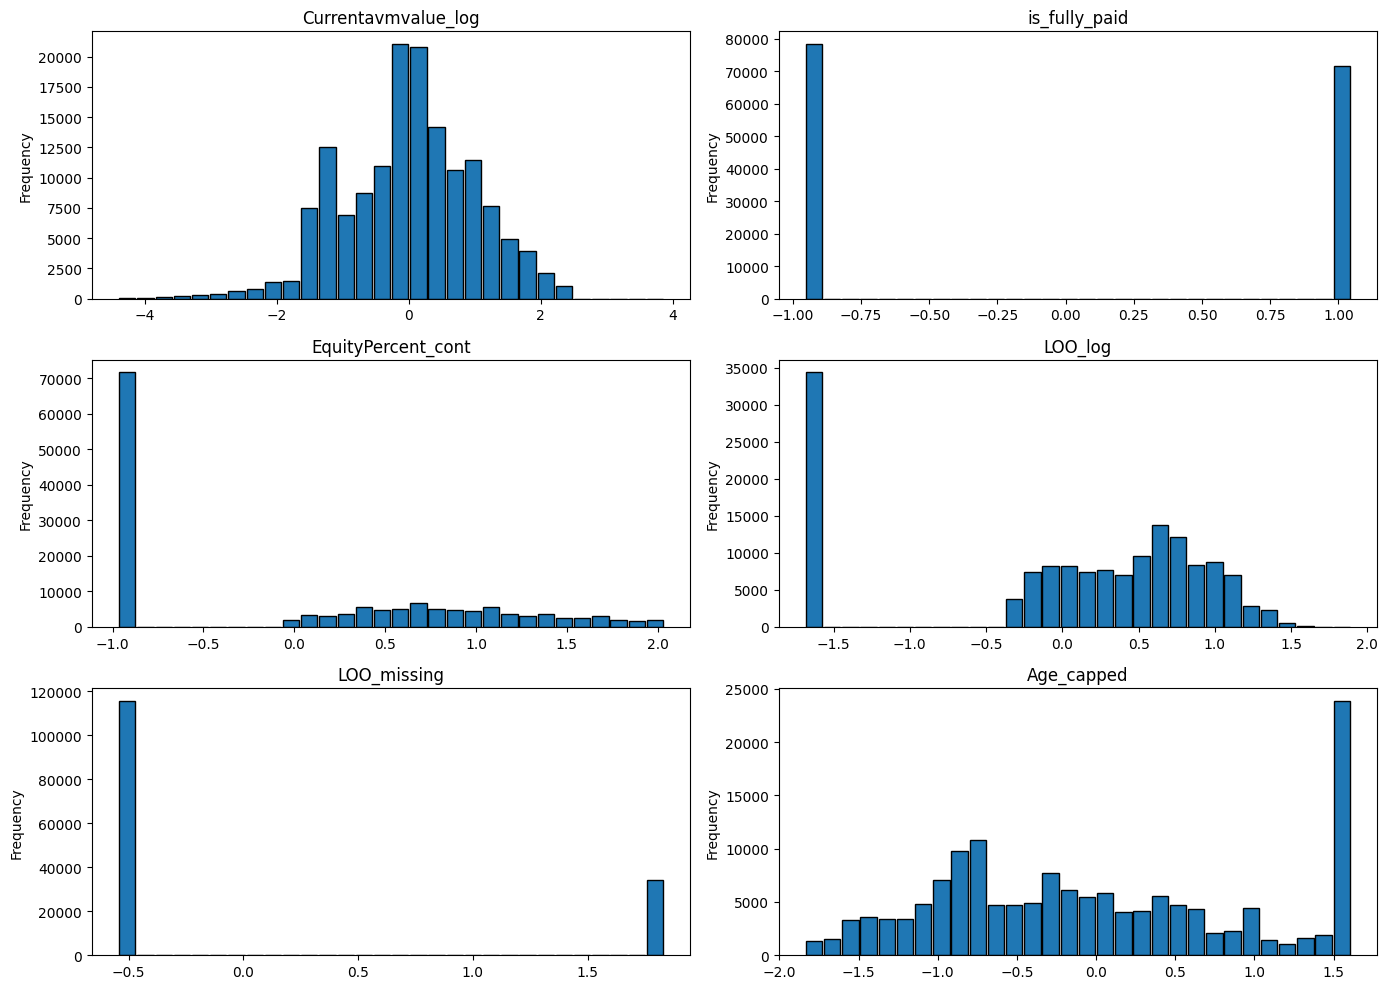

In [37]:
plt.figure(figsize=(14, 10))

for i, col in enumerate(cluster_features):
    ax = plt.subplot(3, 2, i + 1)
    sampled_X_scaled_df[col].plot.hist(
        bins=30,
        edgecolor="black",
        rwidth=0.9,
        ax=ax
    )
    ax.set_title(col)

plt.tight_layout()
plt.show()

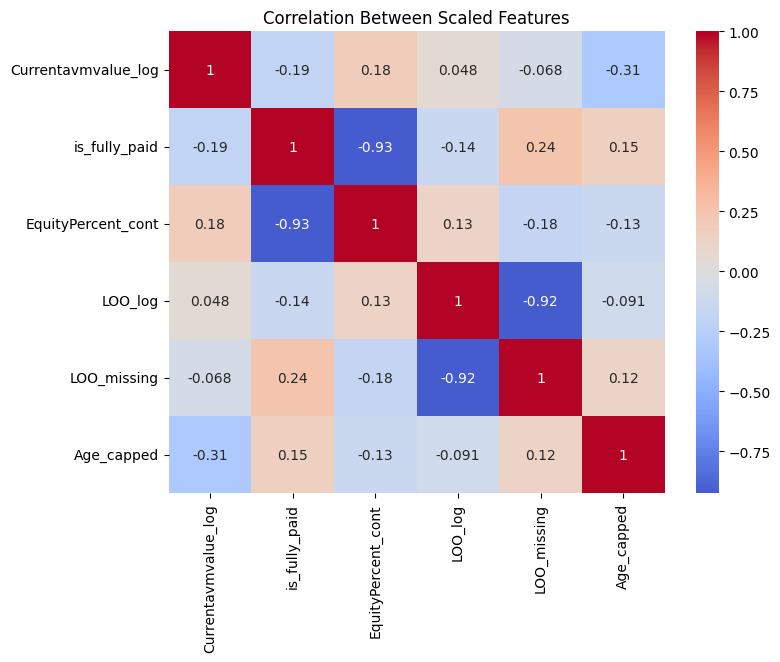

In [38]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(
    sampled_X_scaled_df.corr(),
    annot=True,
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Between Scaled Features")
plt.show()

==> Conclusion: the high correlation is by design, not a problem. e.g.:
- is_fully_paid: Binary state
- EquityPercent_cont: Continuous degree




#### Step 4 -- Algorithm 1: KMeans (first try)

In [39]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=6,
    random_state=42,
    n_init=20
)

labels = kmeans.fit_predict(sampled_X_scaled_df)

sampled_df["cluster"] = labels

In [40]:
cols = cluster_features + ["is_AO"]
sampled_df.groupby("cluster")[cols].mean()

,Currentavmvalue_log,is_fully_paid,EquityPercent_cont,LOO_log,LOO_missing,Age_capped,is_AO
cluster,,,,,,,
0,12.271446,1.0,NaN,3.013170,0.0,82.073836,0.579672
1,12.504206,0.0,59.969247,2.764630,0.0,80.685596,0.381805
2,12.590242,1.0,NaN,NaN,1.0,66.161185,0.556444
3,12.956932,0.0,59.651115,2.723400,0.0,37.819675,0.449652
4,12.725375,0.0,69.807092,NaN,1.0,58.134123,0.390056
5,12.856731,1.0,NaN,3.003546,0.0,42.793858,0.745569


==> conclusion: Clusters are not trivially “AO vs OO”

In [41]:
sampled_df.groupby("cluster").size()

cluster
0    21143
1    25754
2    24015
3    42246
4    10378
5    26463
dtype: int64

##### ==> Result interpretation of Algo 1: KMeans (first try)

#### Conclusions & clusters Evaluation
##### 1. First sanity verdict

Before details:

* ✅ No single cluster dominates (sizes are reasonable)
* ✅ No cluster is tiny/noise
* ✅ Clusters are not trivially “AO vs OO”
* ✅ Equity regime, tenure regime, and AVM are all participating

This means:

> **The geometry is healthy.**

---

## 5. NEXT

### **Step 1 — Stability check**

Run KMeans with different `k` values:

* `k = 5, 6, 7, 8`

Then check:

* Does Cluster 5 persist?
* Does it split meaningfully or dissolve?
* Do legacy clusters remain stable?

If the best cluster vanishes at `k=7`, that’s a warning.

---

### **Step 2 — Translate centroids back to real units**

Right now we’re reading *means*, which is good—but next we should inspect **medians** and **percentiles**, especially for:

* AVM
* EquityPercent
* LOO

Means lie in skewed distributions.

---

### **Step 3 — Attach outcomes (this is where money enters)**

Now we bring in:
`StuckAcqs_4thDecember2025_analysis`

- Process this data EXACTLY as the df_combined dataset and apply the model to get the cluster labels.
- compute ROI for each cluster to find the profitable cluster(s)

---

### **Step 4 — Decide if KMeans is “good enough”**

After outcome analysis:

* If clusters are stable and profitable → keep KMeans
* If clusters bleed together → consider:

  * Gaussian Mixture Models (soft membership)
  * Hierarchical clustering (for sub-segmentation)

But **do not jump algorithms yet**.
KMeans has earned its seat so far.

---

In [42]:
"""# 1. Stability check
from sklearn.cluster import KMeans

k_values = [5, 6, 7, 8]
cluster_results = {}

for k in k_values:
    km = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=20
    )
    labels = km.fit_predict(X_scaled)
    cluster_results[k] = labels

# remove previous clustring column
sampled_df.drop("cluster", axis=1, inplace=True)

for k, labels in cluster_results.items():
    sampled_df[f"cluster_k{k}"] = labels
"""

'# 1. Stability check\nfrom sklearn.cluster import KMeans\n\nk_values = [5, 6, 7, 8]\ncluster_results = {}\n\nfor k in k_values:\n    km = KMeans(\n        n_clusters=k,\n        random_state=42,\n        n_init=20\n    )\n    labels = km.fit_predict(X_scaled)\n    cluster_results[k] = labels\n\n# remove previous clustring column\nsampled_df.drop("cluster", axis=1, inplace=True)\n\nfor k, labels in cluster_results.items():\n    sampled_df[f"cluster_k{k}"] = labels\n'

In [43]:
"""# Compare cluster profiles
for k in k_values:
    print(f"\n=== k = {k} ===")
    display(
        sampled_df
        .groupby(f"cluster_k{k}")[cluster_features + ["is_AO"]]
        .mean()
    )"""

'# Compare cluster profiles\nfor k in k_values:\n    print(f"\n=== k = {k} ===")\n    display(\n        sampled_df\n        .groupby(f"cluster_k{k}")[cluster_features + ["is_AO"]]\n        .mean()\n    )'

==> Conclusion:
- k = 5 → too coarse
- k = 6 → minimum viable resolution
- k = 7, 8 → refinement, not distortion

In [44]:
"""# 2. Compute their membership overlap

gold_k6 = sampled_df.loc[
    (sampled_df["cluster_k6"] == 5)  # 5 is the gold cluster id in k=6
].index

gold_k7 = sampled_df.loc[
    (sampled_df["cluster_k7"] == 0)  # 0 is the gold cluster id in k=7
].index

overlap = len(gold_k6.intersection(gold_k7)) / len(gold_k6)
overlap"""

'# 2. Compute their membership overlap\n\ngold_k6 = sampled_df.loc[\n    (sampled_df["cluster_k6"] == 5)  # 5 is the gold cluster id in k=6\n].index\n\ngold_k7 = sampled_df.loc[\n    (sampled_df["cluster_k7"] == 0)  # 0 is the gold cluster id in k=7\n].index\n\noverlap = len(gold_k6.intersection(gold_k7)) / len(gold_k6)\noverlap'

==> Conclusion:

- high overlap means: The same properties are being grouped together
- Increasing k is not changing membership
- The model is just refining the rest of the space by increasing k

So, This cluster is not an artifact of k. It is a true basin in the data geometry.

### 4. Apply the model to the full dataset

In [45]:
X_full = df_combined[cluster_features].copy()

X_full.loc[X_full['Age_capped'].isna(),'Age_capped'] = max_age_capped
X_full_filled = X_full.fillna(0)

X_full_scaled = scaler.transform(X_full_filled)

# X_scaled is a numpy array
X_full_scaled_df = pd.DataFrame(
    X_full_scaled,
    columns=cluster_features,
    index=df_combined.index
)


X_full_scaled_df.shape

(5300800, 6)

In [46]:
df_combined["cluster"] = kmeans.predict(X_full_scaled_df)

df_combined["cluster"].value_counts(normalize=True).sort_index()

cluster
0    0.140624
1    0.172631
2    0.159669
3    0.280470
4    0.069617
5    0.176990
Name: proportion, dtype: float64

==> Conclusion:
- Full universe ≈ 5.3M
- Cluster 5 ≈ 17.8%  --> almost exactly macthes the sampled dataset fraction

That’s on the order of ~940k properties, We’re not mailing all of them --> Need to be selective inside Cluster 5

### 5. Profit Validation: Does this gold cluster actually make more money?

In [47]:
# read csv file
df_stuckAcqs = pd.read_csv(os.path.join("data", "StuckAcqs_4thDecember2025_analysis.csv"))

# print df length
print("df_stuckAcqs shape: ", df_stuckAcqs.shape)

df_stuckAcqs shape:  (340, 23)


---
#### Computing cluster-level ROI

In [48]:
# Cluster-level ROI

## Step 1: preprocessing
df_stuckAcqs = df_stuckAcqs[~df_stuckAcqs['AVM'].isnull()]
df_stuckAcqs['Equity'] = df_stuckAcqs['Equity'].str.replace('%', '')
df_stuckAcqs['Equity'] = pd.to_numeric(df_stuckAcqs['Equity'])

## Step 2: creating required columns
df_stuckAcqs['Currentavmvalue_log']= np.log1p(df_stuckAcqs['AVM'])
df_stuckAcqs['is_fully_paid'] = (df_stuckAcqs["Equity"] == 100).astype(int)
df_stuckAcqs['EquityPercent_cont'] = df_stuckAcqs['Equity'].where(df_stuckAcqs['Equity']<100)
df_stuckAcqs['LOO_log']= np.log1p(df_stuckAcqs['LOO'])
df_stuckAcqs['LOO_missing'] = (df_stuckAcqs['LOO'].isna()).astype(int)
df_stuckAcqs["Age_capped"] = df_stuckAcqs["Age"].clip(upper=100)
df_stuckAcqs['is_AO'] = (df_stuckAcqs['ListType'] == 'AO').astype(int)


df_stuckAcqs.loc[df_stuckAcqs['Age_capped'].isna(),'Age_capped'] = max_age_capped

stuckAcqs_X = df_stuckAcqs[cluster_features].copy(deep=True)
stuckAcqs_X_filled = stuckAcqs_X.fillna(0)

## Step 3: scaling
stuckAcqs_X_scaled = scaler.transform(stuckAcqs_X_filled)

## Step 4: clustring
df_stuckAcqs_scaled_df = pd.DataFrame(stuckAcqs_X_scaled,
                                          columns = cluster_features,
                                          index = stuckAcqs_X.index)

df_stuckAcqs['cluster'] = kmeans.predict(df_stuckAcqs_scaled_df)

In [49]:
#Step 1 — mails per cluster
df_cluster_mails = (
    df_combined
    .groupby("cluster")
    .size()
    .reset_index(name="mail_count")
)

df_cluster_mails.head(10)

,cluster,mail_count
0,0,745419
1,1,915081
2,2,846372
3,3,1486718
4,4,369024
5,5,938186


In [50]:
#Step 2 — gross margin per cluster (converted only)
df_cluster_conversions = (
    df_stuckAcqs.groupby("cluster")["Gross Margin"].sum()
    .reset_index(name="total_margin")
)

df_cluster_conversions.head(10)

,cluster,total_margin
0,0,1.536279e+06
1,1,6.842986e+05
2,2,6.121593e+06
3,3,1.718205e+06
4,4,2.357044e+06
5,5,2.694037e+06


In [51]:
#Step 3 — compute ROI
cluster_roi = df_cluster_mails.merge(
    df_cluster_conversions,
    on="cluster",
    how="left"
)

cluster_roi['ROI'] = cluster_roi['total_margin']/cluster_roi['mail_count']
print("Total Mails Sent:{}".format(cluster_roi['mail_count'].sum()))
print("Total Margin:{:.2f}".format(cluster_roi['total_margin'].sum()))


Total Mails Sent:5300800
Total Margin:15111456.35


In [52]:
cluster_roi.sort_values("ROI", ascending=False)

,cluster,mail_count,total_margin,ROI
2,2,846372,6.121593e+06,7.232745
4,4,369024,2.357044e+06,6.387238
5,5,938186,2.694037e+06,2.871538
0,0,745419,1.536279e+06,2.060960
3,3,1486718,1.718205e+06,1.155703
1,1,915081,6.842986e+05,0.747801


---

## Market-based clustering

Training data is restricted to a specific market, e.g. 'DC Metro'

- Clustering geometry is learned only from DC Metro
- ROI validation is computed only from DC Metro mail attempts and conversions
- No cross-market leakage
- So Market filtering happens before sampling and training, not after.

In [53]:
#1. Create 'Market' Column in df_stuckAcqs dataset, using ZIP

df_combined["TZip5"] = (df_combined["TZip5"].astype("Int64").astype(str).str.zfill(5))
df_stuckAcqs["Prop Zip"] = (df_stuckAcqs["Prop Zip"].astype("Int64").astype(str).str.zfill(5))

zip_market_lookup = (
    df_combined
    .groupby(["TZip5", "Market"])
    .size()
    .reset_index(name="cnt")
)

# For each ZIP, keep the most frequent Market
zip_market_lookup = (
    zip_market_lookup
    .sort_values(["TZip5", "cnt"], ascending=[True, False])
    .drop_duplicates(subset=["TZip5"])
    [["TZip5", "Market"]]
)

df_stuckAcqs = df_stuckAcqs.merge(
    zip_market_lookup,
    left_on="Prop Zip",      # replace with actual ZIP column name in df_stuckAcqs
    right_on="TZip5",
    how="left"
)

df_stuckAcqs["Market"] = df_stuckAcqs["Market"].fillna("Other")
df_stuckAcqs["Market"].value_counts(dropna=False)

Market
DC Metro         89
Other            82
Baltimore        35
Hampton Roads    31
Richmond         21
Philadelphia      6
Name: count, dtype: int64

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def prepare_features(df):
    X = df[cluster_features].copy()
    
    X.loc[X['Age_capped'].isna(),'Age_capped'] = max_age_capped
    
    return X.fillna(0)

#------------------------------------------------------------------------
def p995(x):
    return x.quantile(0.995)

def p005(x):
    return x.quantile(0.005)

In [55]:
def run_market_pipeline(
    df_combined,
    df_stuckAcqs,
    market_name,
    n_clusters=6,
    target_sample_size=150_000,
    random_state=42,
    compute_cluster_profiles=False
):
    print(f"\n=== Running pipeline for market: {market_name} ===")

    # ---- Step 1: Filter by market & clean old clusters ----
    df_combined_mkt = (
        df_combined[df_combined["Market"] == market_name]
        .drop(columns=["cluster"], errors="ignore")
        .copy()
    )

    df_stuckAcqs_mkt = (
        df_stuckAcqs[df_stuckAcqs["Market"] == market_name]
        .drop(columns=["cluster"], errors="ignore")
        .copy()
    )

    if len(df_combined_mkt) == 0:
        raise ValueError(f"No rows in df_combined for market {market_name}")

    # ---- Step 2: Stratified sampling (training only) ----
    sample_frac = min(1.0, target_sample_size / len(df_combined_mkt))

    sampled_mkt = (
        df_combined_mkt
        .groupby(
            ["AVM_bin", "LOO_missing"],
            observed=False
        )
        .sample(
            frac=sample_frac,
            random_state=random_state
        )
    )

    # ---- Step 3: Train scaler + clustering ----
    X_train = prepare_features(sampled_mkt)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # X_scaled is a numpy array
    X_train_scaled_df = pd.DataFrame(
        X_train_scaled,
        columns=cluster_features,
        index=sampled_mkt.index
    )

    kmeans_mkt = KMeans(n_clusters=6, random_state=42, n_init=10)
    kmeans_mkt.fit(X_train_scaled_df)

    # ---- Step 4: Apply model to full market universe ----
    X_full = prepare_features(df_combined_mkt)
    X_full_scaled = scaler.transform(X_full)

    X_full_scaled_df = pd.DataFrame(
        X_full_scaled,
        columns=cluster_features,
        index=df_combined_mkt.index
    )

    df_combined_mkt["cluster"] = kmeans_mkt.predict(X_full_scaled_df)

    # ---- Step 5: Apply model to conversions ----
    if len(df_stuckAcqs_mkt) > 0:
        X_stuck = prepare_features(df_stuckAcqs_mkt)
        X_stuck_scaled = scaler.transform(X_stuck)

        X_stuck_scaled_df = pd.DataFrame(
            X_stuck_scaled,
            columns=cluster_features,
            index=X_stuck.index
        )
        df_stuckAcqs_mkt["cluster"] = kmeans_mkt.predict(X_stuck_scaled_df)
    else:
        df_stuckAcqs_mkt["cluster"] = []

    # ---- Step 6: Compute ROI at cluster level ----
    df_cluster_mails = (
        df_combined_mkt
        .groupby(["cluster", "is_AO"])
        .size()
        .reset_index(name="mail_count")
    )

    df_cluster_conversions = (
        df_stuckAcqs_mkt.groupby(["cluster", "is_AO"]).agg(
        total_margin=("Gross Margin", "sum"),
        number_conversions=("Gross Margin", "count")
        )
        .reset_index()
    )

    cluster_roi = df_cluster_mails.merge(
        df_cluster_conversions,
        on=["cluster", "is_AO"],
        how="left"
    )

    cluster_roi["total_margin"] = cluster_roi["total_margin"].fillna(0)
    cluster_roi["ROI"] = (cluster_roi["total_margin"] / cluster_roi["mail_count"])

    cluster_roi["ownership_type"] = cluster_roi["is_AO"].map({1: "AO", 0: "OO"}
    )

    cluster_roi = cluster_roi.sort_values("ROI", ascending=False)
    
    # Step 7: 
    cluster_profile_by_ownership = None

    if compute_cluster_profiles:

        cluster_profile_by_ownership = (
            df_combined_mkt
            .groupby(["cluster", "is_AO"])
            .agg(
                LOO_min=("LOO", "min"),
                LOO_max=("LOO", "max"),

                Equity_min=("EquityPercent", "min"),
                Equity_max=("EquityPercent", "max"),

                Age_p005=("Age_capped", p005),
                Age_p995=("Age_capped", p995),

                AVM_p005=("Currentavmvalue", p005),
                AVM_p995=("Currentavmvalue", p995),
                property_count=("PropertyID", "count")
            )
            .reset_index()
        )

        cluster_profile_by_ownership["ownership_type"] = (
            cluster_profile_by_ownership["is_AO"].map({1: "AO", 0: "OO"})
        )

    return {
        "market": market_name,
        "cluster_roi": cluster_roi,
        "model": kmeans_mkt,
        "scaler": scaler,
        "df_combined_mkt": df_combined_mkt,
        "df_stuckAcqs_mkt": df_stuckAcqs_mkt,
        "cluster_profile_by_ownership": cluster_profile_by_ownership
    }

In [56]:
markets_list = ["DC Metro", "Baltimore", "Hampton Roads", "Richmond", "Philadelphia"]

market_results = {}

for mkt in markets_list:
    market_results[mkt] = run_market_pipeline(
        df_combined=df_combined,
        df_stuckAcqs=df_stuckAcqs,
        market_name=mkt,
        compute_cluster_profiles=True
    )


=== Running pipeline for market: DC Metro ===

=== Running pipeline for market: Baltimore ===

=== Running pipeline for market: Hampton Roads ===

=== Running pipeline for market: Richmond ===

=== Running pipeline for market: Philadelphia ===


In [57]:
# Build the cross-market ROI table (AO-split)
roi_all_markets = []

for mkt, res in market_results.items():
    tmp = res["cluster_roi"].copy()
    tmp["Market"] = mkt
    roi_all_markets.append(tmp)

roi_all_markets = pd.concat(roi_all_markets, ignore_index=True)


roi_all_markets["ROI_rank_in_market"] = (
    roi_all_markets
    .groupby(["Market", "ownership_type"])["ROI"]
    .rank(ascending=False, method="dense")
)

---
### Stability / robustness analysis

#### 1. quantify how concentrated the ROI is in each top cluster

In [58]:
def concentration_metrics(df_stuckAcqs_mkt):
    rows = []
    
    for (mkt, cluster, is_AO), g in df_stuckAcqs_mkt.groupby(
        ["Market", "cluster", "is_AO"]
    ):
        margins = g["Gross Margin"].sort_values(ascending=False)
        total = margins.sum()

        if total <= 0:
            rows.append({
                "Market": mkt,
                "cluster": cluster,
                "is_AO": is_AO,
                "conversion_count": len(margins),
                "avg_margin_per_conversion": np.nan,
                "top1_share": 0.0,
                "top3_share": 0.0
            })
            continue

        rows.append({
            "Market": mkt,
            "cluster": cluster,
            "is_AO": is_AO,
            "conversion_count": len(margins),
            "avg_margin_per_conversion": margins.mean(),
            "top1_share": margins.iloc[0] / total,
            "top3_share": margins.iloc[:3].sum() / total
        })

    return pd.DataFrame(rows)


#### 2. Define a Stability Score (simple, interpretable)

Stability Score = (1 − top1_share) × (1 − top3_share) × log(1 + conversion_count)

- (1 − top1_share)
    - Penalizes reliance on a single deal

- (1 − top3_share)
    - Penalizes reliance on very few deals

- log(1 + conversion_count)
    - Rewards more evidence, but with diminishing returns
    - (going from 1→2 matters more than 20→21)

- This produces:
    - higher values = more stable
    - zero or near-zero values = very fragile


#### Interpretation
1. Do not use Stability Score alone
2. Do not compare Stability Scores across very different markets without context
3. Always interpret it together with ROI and volume

- High ROI + high Stability Score
→ True gold (scale confidently)

- High ROI + low Stability Score
→ Speculative (cap volume, monitor)

- Low ROI + high Stability Score
→ Consistently unprofitable (suppress)

- Low ROI + low Stability Score
→ Ignore

In [59]:
stability_tables = []

for mkt, res in market_results.items():
    df_stuck = res["df_stuckAcqs_mkt"].copy()
    df_stuck["Market"] = mkt
    stability_tables.append(concentration_metrics(df_stuck))

stability = pd.concat(stability_tables, ignore_index=True)
stability["ownership_type"] = stability["is_AO"].map({1: "AO", 0: "OO"})

stability_clean = stability.drop(columns=["is_AO","conversion_count"], errors="ignore")
#---------------------------------------------------------------

roi_all_markets = roi_all_markets.drop(columns=["is_AO"], errors="ignore")



roi_with_stability = roi_all_markets.merge(
    stability_clean,
    on=["Market", "cluster", "ownership_type"],
    how="left"
)

roi_with_stability.sort_values(
    ["Market", "ROI_rank_in_market"]
)


roi_with_stability["stability_score"] = (
    (1 - roi_with_stability["top1_share"]) *
    (1 - roi_with_stability["top3_share"]) *
    np.log1p(roi_with_stability["number_conversions"])
)

roi_with_stability["risk_adjusted_ROI"] = (
    roi_with_stability["ROI"] *
    roi_with_stability["stability_score"]
)

## NEXT: Designing a scoring system
- First layer: Based on the cluster's rank in each market --> Base score
- Second layer: Based on available features (e.g. AO, LOO_log, Age_capped, etc.)


Final Score =
    Base Score (Cluster State) + AO Modifier + AVM Tier Modifier + Age Band Modifier

1. cluster_state	Meaning
- C1	Best    ---        High ROI + High Stability (prioritize)
- C2	High    ---        ROI + Low Stability (cap / monitor)
- C3	Low     ---        ROI + High Stability (suppress)
- C4	Worst   ---        Low ROI + Low Stability (ignore)

In [60]:
roi_with_stability["ROI_pct"] = (
    roi_with_stability
    .groupby(["Market", "ownership_type"])["ROI"]
    .rank(pct=True)
)

roi_with_stability["stability_pct"] = (
    roi_with_stability
    .groupby(["Market", "ownership_type"])["stability_score"]
    .rank(pct=True)
)

In [61]:
# Assign cluster_state (C1–C4)
def assign_cluster_state_C(row):
    high_roi = row["ROI_pct"] >= 0.60
    high_stability = row["stability_pct"] >= 0.60

    if high_roi and high_stability:
        return "C1"   # Best
    elif high_roi and not high_stability:
        return "C2"   # Speculative
    elif not high_roi and high_stability:
        return "C3"   # Consistently Bad
    else:
        return "C4"   # Ignore

roi_with_stability["cluster_state"] = (
    roi_with_stability.apply(assign_cluster_state_C, axis=1)
)


In [62]:
roi_with_stability

,cluster,mail_count,total_margin,number_conversions,ROI,ownership_type,Market,ROI_rank_in_market,avg_margin_per_conversion,top1_share,top3_share,stability_score,risk_adjusted_ROI,ROI_pct,stability_pct,cluster_state
0,3,51032,1.167293e+06,15.0,22.873745,AO,DC Metro,1.0,77819.530667,0.141162,0.379325,1.477953,33.806323,1.000000,0.666667,C1
1,5,160019,1.551248e+06,20.0,9.694149,AO,DC Metro,2.0,77562.398000,0.137685,0.356503,1.689396,16.377258,0.833333,1.000000,C1
2,5,93310,4.388564e+05,7.0,4.703209,OO,DC Metro,1.0,62693.770001,0.227564,0.588875,0.660364,3.105829,1.000000,0.833333,C1
3,1,78683,2.999982e+05,4.0,3.812745,OO,DC Metro,2.0,74999.562500,0.367253,0.870976,0.131393,0.500970,0.833333,0.500000,C2
4,3,68182,2.423905e+05,2.0,3.555050,OO,DC Metro,3.0,121195.225000,0.542813,1.000000,0.000000,0.000000,0.666667,0.250000,C2
5,4,79860,2.800181e+05,5.0,3.506363,OO,DC Metro,4.0,56003.624000,0.337416,0.768888,0.274374,0.962055,0.500000,0.666667,C3
6,2,282283,7.497562e+05,15.0,2.656045,AO,DC Metro,3.0,49983.747667,0.128747,0.375634,1.508235,4.005938,0.666667,0.833333,C1
7,0,129791,3.162642e+05,6.0,2.436719,AO,DC Metro,4.0,52710.701667,0.409307,0.754470,0.282221,0.687692,0.500000,0.500000,C4
8,2,354334,5.690023e+05,7.0,1.605836,OO,DC Metro,5.0,81286.044286,0.219503,0.568834,0.699782,1.123736,0.333333,1.000000,C3
9,1,248214,2.250557e+05,4.0,0.906700,AO,DC Metro,5.0,56263.920000,0.427827,0.869357,0.120306,0.109082,0.333333,0.333333,C4


In [63]:
# save to excel

roi_with_stability.to_excel(
    "/Users/Home/Documents/MyProjects/Property_clustring/roi_with_stability.xlsx"
)

In [64]:
# Merge feature profiles

cluster_feature_ranges = []

for mkt, res in market_results.items():
    tmp = res["cluster_profile_by_ownership"].copy()
    tmp["Market"] = mkt
    cluster_feature_ranges.append(tmp)

cluster_feature_ranges = pd.concat(cluster_feature_ranges, ignore_index=True)

cluster_feature_ranges = cluster_feature_ranges.drop(columns=['is_AO', 'property_count'], errors="ignore")

# Final merge
final_comparison_table = roi_with_stability.merge(
    cluster_feature_ranges,
    on=["Market", "cluster", "ownership_type"],
    how="left"
)

In [65]:
final_comparison_table

,cluster,mail_count,total_margin,number_conversions,ROI,ownership_type,Market,ROI_rank_in_market,avg_margin_per_conversion,top1_share,top3_share,stability_score,risk_adjusted_ROI,ROI_pct,stability_pct,cluster_state,LOO_min,LOO_max,Equity_min,Equity_max,Age_p005,Age_p995,AVM_p005,AVM_p995
0,3,51032,1.167293e+06,15.0,22.873745,AO,DC Metro,1.0,77819.530667,0.141162,0.379325,1.477953,33.806323,1.000000,0.666667,C1,NaN,NaN,30,99,12.000,100.0,135056.560,989000.000
1,5,160019,1.551248e+06,20.0,9.694149,AO,DC Metro,2.0,77562.398000,0.137685,0.356503,1.689396,16.377258,0.833333,1.000000,C1,NaN,NaN,100,100,13.000,100.0,86000.000,981000.000
2,5,93310,4.388564e+05,7.0,4.703209,OO,DC Metro,1.0,62693.770001,0.227564,0.588875,0.660364,3.105829,1.000000,0.833333,C1,NaN,NaN,100,100,18.000,100.0,74963.600,973000.000
3,1,78683,2.999982e+05,4.0,3.812745,OO,DC Metro,2.0,74999.562500,0.367253,0.870976,0.131393,0.500970,0.833333,0.500000,C2,4.985626,69.185489,100,100,12.000,100.0,184127.690,992000.000
4,3,68182,2.423905e+05,2.0,3.555050,OO,DC Metro,3.0,121195.225000,0.542813,1.000000,0.000000,0.000000,0.666667,0.250000,C2,NaN,NaN,30,99,13.000,100.0,142527.615,978000.000
5,4,79860,2.800181e+05,5.0,3.506363,OO,DC Metro,4.0,56003.624000,0.337416,0.768888,0.274374,0.962055,0.500000,0.666667,C3,4.982888,74.171116,100,100,26.000,100.0,57511.065,669893.210
6,2,282283,7.497562e+05,15.0,2.656045,AO,DC Metro,3.0,49983.747667,0.128747,0.375634,1.508235,4.005938,0.666667,0.833333,C1,4.982888,107.063655,30,99,11.000,70.0,206361.410,988000.000
7,0,129791,3.162642e+05,6.0,2.436719,AO,DC Metro,4.0,52710.701667,0.409307,0.754470,0.282221,0.687692,0.500000,0.500000,C4,4.982888,66.798084,30,99,41.000,100.0,98000.000,965000.000
8,2,354334,5.690023e+05,7.0,1.605836,OO,DC Metro,5.0,81286.044286,0.219503,0.568834,0.699782,1.123736,0.333333,1.000000,C3,4.982888,67.312799,30,99,11.000,63.0,180000.000,988000.000
9,1,248214,2.250557e+05,4.0,0.906700,AO,DC Metro,5.0,56263.920000,0.427827,0.869357,0.120306,0.109082,0.333333,0.333333,C4,4.982888,68.591376,100,100,12.000,100.0,226605.745,980000.000


In [66]:
# Save to excel

final_comparison_table.to_excel(
    "/Users/Home/Documents/MyProjects/Property_clustring/final_comparison_table.xlsx"
)

In [67]:
DC_Metro_df = final_comparison_table[final_comparison_table['Market']=='DC Metro']
# save to excel

DC_Metro_df.to_excel(
    "/Users/Home/Documents/MyProjects/Property_clustring/DC_Metro_df.xlsx"
)

In [95]:
final_comparison_table[(final_comparison_table['Market']=='DC Metro') & (final_comparison_table['cluster_state']=='C1') & (final_comparison_table['ownership_type']=='AO')]

,cluster,mail_count,total_margin,number_conversions,ROI,ownership_type,Market,ROI_rank_in_market,avg_margin_per_conversion,top1_share,top3_share,stability_score,risk_adjusted_ROI,ROI_pct,stability_pct,cluster_state,LOO_min,LOO_max,Equity_min,Equity_max,Age_p005,Age_p995,AVM_p005,AVM_p995
0,3,51032,1167292.960,15.0,22.873745,AO,DC Metro,1.0,77819.530667,0.141162,0.379325,1.477953,33.806323,1.000000,0.666667,C1,NaN,NaN,30,99,12.0,100.0,135056.56,989000.0
1,5,160019,1551247.960,20.0,9.694149,AO,DC Metro,2.0,77562.398000,0.137685,0.356503,1.689396,16.377258,0.833333,1.000000,C1,NaN,NaN,100,100,13.0,100.0,86000.00,981000.0
6,2,282283,749756.215,15.0,2.656045,AO,DC Metro,3.0,49983.747667,0.128747,0.375634,1.508235,4.005938,0.666667,0.833333,C1,4.982888,107.063655,30,99,11.0,70.0,206361.41,988000.0


### Actionable granularity inside C1/C2

Market
 
└─ Ownership (AO / OO)

    └─ Cluster (C1–C4)
 
       └─ Sub-segments (AVM , LOO , Age)


In [79]:
# Sub-segments based on AVM 

#Example for one market (DC Metro), AO, cluster C1

c1_clusters_dc_ao = (
    final_comparison_table
    .query("Market == 'DC Metro' and ownership_type == 'AO' and cluster_state == 'C1'")
    ["cluster"]
    .unique()
)

In [80]:
c1_clusters_dc_ao

array([3, 5, 2])

In [82]:
df_universe = (
    market_results["DC Metro"]["df_combined_mkt"]
    .query("cluster in @c1_clusters_dc_ao and is_AO == 1")
    .copy()
)

median_avm = df_universe["Currentavmvalue"].median()

df_universe["AVM_50_tier"] = np.where(
    df_universe["Currentavmvalue"] >= median_avm,
    "High_AVM",
    "Low_AVM"
)

In [84]:
df_conv = (
    market_results["DC Metro"]["df_stuckAcqs_mkt"]
    .query("cluster in @c1_clusters_dc_ao and is_AO == 1")
    .copy()
)

df_conv["AVM_50_tier"] = np.where(
    df_conv["AVM"] >= median_avm,
    "High_AVM",
    "Low_AVM"
)

In [87]:
# Aggregate mail volume by AVM tier
mail_by_avm = (
    df_universe
    .groupby("AVM_50_tier")
    .size()
    .reset_index(name="mail_count")
)

# Aggregate conversions and margin by AVM tier
conv_by_avm = (
    df_conv
    .groupby("AVM_50_tier")
    .agg(
        conversion_count=("Gross Margin", "count"),
        total_margin=("Gross Margin", "sum"),
        avg_margin=("Gross Margin", "mean")
    )
    .reset_index()
)

# Step 3 — Merge exposure and outcomes
avm_50_summary = mail_by_avm.merge(
    conv_by_avm,
    on="AVM_50_tier",
    how="left"
)

avm_50_summary["conversion_count"] = (
    avm_50_summary["conversion_count"].fillna(0)
)

avm_50_summary["total_margin"] = (
    avm_50_summary["total_margin"].fillna(0)
)

avm_50_summary["ROI"] = (
    avm_50_summary["total_margin"] / avm_50_summary["mail_count"]
)

In [ ]:
# DC Metro, AO, C1 split based on AVM
avm_50_summary

,AVM_50_tier,mail_count,conversion_count,total_margin,avg_margin,ROI
0,High_AVM,247037,20,1852212.300,92610.6150,7.497712
1,Low_AVM,246297,30,1616084.835,53869.4945,6.561529


==> Conclusion: High_AVM should be prioritized; Low_AVM should be volume-managed

---
For all markets
---

In [111]:
import numpy as np
import pandas as pd

# ============================================================
# Build comparison_table_avm
# Market × cluster × ownership_type × AVM_50_tier
# ============================================================

avm_split_rows = []

for mkt, res in market_results.items():

    df_univ_all = res["df_combined_mkt"].copy()
    df_conv_all = res["df_stuckAcqs_mkt"].copy()

    # Safety: ensure cluster dtype alignment
    df_univ_all["cluster"] = df_univ_all["cluster"].astype(int)
    df_conv_all["cluster"] = df_conv_all["cluster"].astype(int)

    # Ensure is_AO exists in conversions
    if "is_AO" not in df_conv_all.columns:
        if "ownership_type" in df_conv_all.columns:
            df_conv_all["is_AO"] = (df_conv_all["ownership_type"] == "AO").astype(int)
        elif "FinalOwnerType" in df_conv_all.columns:
            df_conv_all["is_AO"] = (df_conv_all["FinalOwnerType"] == "AO").astype(int)

    # Loop over cluster × ownership in the universe
    for (cluster, is_AO), g_univ in df_univ_all.groupby(["cluster", "is_AO"]):

        # Skip very small universe groups
        if len(g_univ) < 1000:
            continue

        # ---- Step 4: compute AVM median within group
        median_avm = g_univ["Currentavmvalue"].median()

        # ---- Step 5: assign AVM_50_tier to universe
        g_univ = g_univ.copy()
        g_univ["AVM_50_tier"] = np.where(
            g_univ["Currentavmvalue"] >= median_avm,
            "High_AVM",
            "Low_AVM"
        )

        # ---- Step 6: get matching conversions
        g_conv = df_conv_all[
            (df_conv_all["cluster"] == cluster) &
            (df_conv_all["is_AO"] == is_AO)
        ].copy()

        if len(g_conv) > 0:
            g_conv["AVM_50_tier"] = np.where(
                g_conv["AVM"] >= median_avm,
                "High_AVM",
                "Low_AVM"
            )

        # ---- Step 7: aggregate mail exposure
        mail_stats = (
            g_univ
            .groupby("AVM_50_tier")
            .size()
            .reset_index(name="mail_count")
        )

        # ---- Step 8: aggregate conversions
        if len(g_conv) > 0:
            conv_stats = (
            g_conv
            .groupby("AVM_50_tier")
            .agg(
                conversion_count=("Gross Margin", "count"),
                total_margin=("Gross Margin", "sum")
            )
            .reset_index()
            )
        else:
            conv_stats = pd.DataFrame(
                columns=["AVM_50_tier", "conversion_count", "total_margin"]
        )

        # ---- Step 9: merge & compute ROI
        merged = mail_stats.merge(
            conv_stats,
            on="AVM_50_tier",
            how="left"
        )

        merged["conversion_count"] = merged["conversion_count"].fillna(0)
        merged["total_margin"] = merged["total_margin"].fillna(0)
        merged["ROI"] = merged["total_margin"] / merged["mail_count"]

        # ---- Step 10: add identifiers
        merged["Market"] = mkt
        merged["cluster"] = cluster
        merged["is_AO"] = is_AO
        merged["ownership_type"] = "AO" if is_AO == 1 else "OO"

        avm_split_rows.append(merged)

# ---- Step 11: final AVM comparison table
comparison_table_avm = pd.concat(
    avm_split_rows,
    ignore_index=True
)

# Optional sort for readability
comparison_table_avm = comparison_table_avm.sort_values(
    ["Market", "ownership_type", "cluster", "AVM_50_tier"]
).reset_index(drop=True)

comparison_table_avm


C:\Users\Home\AppData\Local\Temp\ipykernel_13076\2716791470.py:89: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged["conversion_count"] = merged["conversion_count"].fillna(0)
C:\Users\Home\AppData\Local\Temp\ipykernel_13076\2716791470.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged["total_margin"] = merged["total_margin"].fillna(0)
C:\Users\Home\AppData\Local\Temp\ipykernel_13076\2716791470.py:89: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_

,AVM_50_tier,mail_count,conversion_count,total_margin,ROI,Market,cluster,is_AO,ownership_type
0,High_AVM,37701,1.0,1.147907e+05,3.044766,Baltimore,0,1,AO
1,Low_AVM,37700,3.0,1.555872e+05,4.126981,Baltimore,0,1,AO
2,High_AVM,87152,3.0,1.826458e+05,2.095716,Baltimore,1,1,AO
3,Low_AVM,86815,5.0,6.313729e+04,0.727262,Baltimore,1,1,AO
4,High_AVM,23830,1.0,1.291083e+05,5.417889,Baltimore,2,1,AO
5,Low_AVM,23490,3.0,1.511940e+05,6.436526,Baltimore,2,1,AO
6,High_AVM,73657,0.0,0.000000e+00,0.000000,Baltimore,3,1,AO
7,Low_AVM,73656,0.0,0.000000e+00,0.000000,Baltimore,3,1,AO
8,High_AVM,63527,1.0,9.589741e+04,1.509554,Baltimore,4,1,AO
9,Low_AVM,63158,1.0,3.656522e+04,0.578948,Baltimore,4,1,AO


In [113]:
comparison_table_avm_enriched = comparison_table_avm.merge(
    final_comparison_table[
        [
            "Market",
            "cluster",
            "ownership_type",
            "top1_share",
            "top3_share",
            "stability_score",
            "risk_adjusted_ROI",
            "ROI_pct",
            "stability_pct",
            "cluster_state",
            "LOO_min",
            "LOO_max",
            "Equity_min",
            "Equity_max",
            "Age_p005",
            "Age_p995",
            "AVM_p005",
            "AVM_p995"
        ]
    ],
    on=["Market", "cluster", "ownership_type"],
    how="left"
)


comparison_table_avm_enriched

,AVM_50_tier,mail_count,conversion_count,total_margin,ROI,Market,cluster,is_AO,ownership_type,top1_share,top3_share,stability_score,risk_adjusted_ROI,ROI_pct,stability_pct,cluster_state,LOO_min,LOO_max,Equity_min,Equity_max,Age_p005,Age_p995,AVM_p005,AVM_p995
0,High_AVM,37701,1.0,1.147907e+05,3.044766,Baltimore,0,1,AO,0.424557,0.894384,0.097815,0.350753,0.666667,0.800000,C1,4.982888,75.195072,30,99,42.000,100.0,82000.000,819000.000
1,Low_AVM,37700,3.0,1.555872e+05,4.126981,Baltimore,0,1,AO,0.424557,0.894384,0.097815,0.350753,0.666667,0.800000,C1,4.982888,75.195072,30,99,42.000,100.0,82000.000,819000.000
2,High_AVM,87152,3.0,1.826458e+05,2.095716,Baltimore,1,1,AO,0.340800,0.957579,0.061443,0.086807,0.500000,0.600000,C3,4.982888,77.845311,100,100,12.000,100.0,158000.000,956000.000
3,Low_AVM,86815,5.0,6.313729e+04,0.727262,Baltimore,1,1,AO,0.340800,0.957579,0.061443,0.086807,0.500000,0.600000,C3,4.982888,77.845311,100,100,12.000,100.0,158000.000,956000.000
4,High_AVM,23830,1.0,1.291083e+05,5.417889,Baltimore,2,1,AO,0.460604,0.883125,0.101462,0.601017,0.833333,1.000000,C1,NaN,NaN,100,100,14.000,100.0,52000.000,939000.000
5,Low_AVM,23490,3.0,1.511940e+05,6.436526,Baltimore,2,1,AO,0.460604,0.883125,0.101462,0.601017,0.833333,1.000000,C1,NaN,NaN,100,100,14.000,100.0,52000.000,939000.000
6,High_AVM,73657,0.0,0.000000e+00,0.000000,Baltimore,3,1,AO,NaN,NaN,NaN,NaN,0.166667,NaN,C4,4.982888,70.332649,30,99,11.000,75.0,177000.000,973000.000
7,Low_AVM,73656,0.0,0.000000e+00,0.000000,Baltimore,3,1,AO,NaN,NaN,NaN,NaN,0.166667,NaN,C4,4.982888,70.332649,30,99,11.000,75.0,177000.000,973000.000
8,High_AVM,63527,1.0,9.589741e+04,1.509554,Baltimore,4,1,AO,0.723958,1.000000,0.000000,0.000000,0.333333,0.300000,C4,4.982888,74.584531,100,100,39.000,100.0,47056.780,595000.000
9,Low_AVM,63158,1.0,3.656522e+04,0.578948,Baltimore,4,1,AO,0.723958,1.000000,0.000000,0.000000,0.333333,0.300000,C4,4.982888,74.584531,100,100,39.000,100.0,47056.780,595000.000


### ==> NOTE: AVM tiers are a prioritization lens inside a cluster

- Cluster defines the behavioral regime
- AVM just tells you which half to mail more
- Stability, feature ranges, cluster_state stay inherited

In [114]:
# Save to excel

comparison_table_avm_enriched.to_excel(
    "/Users/Home/Documents/MyProjects/Property_clustring/comparison_table_avm_enriched.xlsx"
)